In [14]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation


%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import requests
import time
import datetime

In [4]:
CURRENCIES = {
    'Bitcoin' : 'BTC', 
    'Ethereum' : 'ETH', 
    'Litecoin' : 'LTC',
    'AdEx' : 'ADX', 
    'Substratum' : 'SUB',
    'Ripple' : 'XRP',
    'NEO' : 'NEO',
    'IOTA' : 'IOT',
    'Monero' : 'XMR',
             }
TARGET_CURRENCY = 'USD'

In [5]:
PRICE_HISTORY_BASE_URL = 'https://min-api.cryptocompare.com/data/histoday'
REQUEST_PARAMS = '?fsym={source_currency}&tsym={target_currency}&aggregate=1&e=CCCAGG&allData=1'
TEMPLATE_REQUEST_URL = PRICE_HISTORY_BASE_URL + REQUEST_PARAMS

In [6]:
# Obtain historical data from the beginning of time for each currency
currency_dataframe = {}
for currency, symbol in CURRENCIES.items():
    request_url = TEMPLATE_REQUEST_URL.format(source_currency = symbol, target_currency = TARGET_CURRENCY)
    print('Fetching historical market data for {} ({} -> {}) ....'.format(currency, symbol, TARGET_CURRENCY))
    print('Request URL :', request_url)
    json_response = requests.get(url = request_url).json()
    if json_response['Response'] == 'Error':
        print('Failed to fetch historical market data for {} ({} -> {}) !, Error Message : {}'
              .format(currency, symbol, TARGET_CURRENCY, json_response['Message']))
    else:
        # print(json_response)
        df = pd.DataFrame(json_response['Data'])
        # convert time (unix timestamp) to date
        df['date'] = pd.to_datetime(df['time'], unit = 's')
        # drop time column
        df.drop('time', axis = 1, inplace = True)
        # set date column as index
        df.set_index('date', inplace = True)
        
        # volumefrom : trading volume of source currency traded (ex: BTC)
        # volumeto : trading volume of target currency traded (ex: USD)
        # average price of 1 unit of the source currency in the target currency = volumeto / volumefrom
        df.rename(columns = {'open': 'market_open', 'close': 'market_close',
                             'low': 'market_low', 'high': 'market_high',
                             'volumefrom': 'trading_volume_source_currency', 
                             'volumeto': 'trading_volume_target_currency'}, inplace = True)
        currency_dataframe[currency] = df
        print('Successfully fetched historical market data for {} !'.format(currency, symbol))
    # sleep for 1s to avoid hitting max rate limit per second
    time.sleep(1)
        

Fetching historical market data for Bitcoin (BTC -> USD) ....
Request URL : https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&aggregate=1&e=CCCAGG&allData=1
Successfully fetched historical market data for Bitcoin !
Fetching historical market data for Ethereum (ETH -> USD) ....
Request URL : https://min-api.cryptocompare.com/data/histoday?fsym=ETH&tsym=USD&aggregate=1&e=CCCAGG&allData=1
Successfully fetched historical market data for Ethereum !
Fetching historical market data for Litecoin (LTC -> USD) ....
Request URL : https://min-api.cryptocompare.com/data/histoday?fsym=LTC&tsym=USD&aggregate=1&e=CCCAGG&allData=1
Successfully fetched historical market data for Litecoin !
Fetching historical market data for AdEx (ADX -> USD) ....
Request URL : https://min-api.cryptocompare.com/data/histoday?fsym=ADX&tsym=USD&aggregate=1&e=CCCAGG&allData=1
Successfully fetched historical market data for AdEx !
Fetching historical market data for Substratum (SUB -> USD) ....
Request URL :

In [7]:
df = currency_dataframe['Bitcoin']

In [8]:
df.head()

,market_close,market_high,market_low,market_open,trading_volume_source_currency,trading_volume_target_currency
date,,,,,,
2010-07-17,0.04951,0.04951,0.04951,0.04951,20.00,0.9902
2010-07-18,0.08584,0.08585,0.05941,0.04951,75.01,5.0900
2010-07-19,0.08080,0.09307,0.07723,0.08584,574.00,49.6600
2010-07-20,0.07474,0.08181,0.07426,0.08080,262.00,20.5900
2010-07-21,0.07921,0.07921,0.06634,0.07474,575.00,42.2600


In [9]:
df.describe()

,market_close,market_high,market_low,market_open,trading_volume_source_currency,trading_volume_target_currency
count,2829.000000,2829.000000,2829.000000,2829.000000,2829.000000,2.829000e+03
mean,1086.280510,1127.778814,1032.573439,1083.453670,55810.823722,1.232027e+08
std,2636.613107,2755.801519,2478.061253,2633.497819,56332.164944,4.144453e+08
min,0.049510,0.049510,0.010000,0.049510,0.000000,0.000000e+00
25%,10.890000,11.130000,10.550000,10.870000,18057.570000,3.874762e+05
50%,255.920000,264.710000,248.280000,255.590000,40360.360000,6.143389e+06
75%,626.580000,638.590000,613.010000,625.570000,74152.690000,2.661345e+07
max,19345.490000,19870.620000,18750.910000,19346.600000,572349.320000,6.245732e+09


In [10]:
df.shape

(2829, 6)

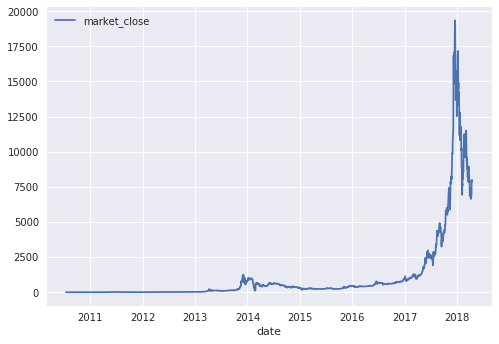

In [12]:
df[['market_close']].plot()

In [16]:
current_date = datetime.datetime.now().strftime("%Y-%m-%d")
current_date

'2018-04-14'

In [ ]:
def get_currency_timeseries(currency_dataframe, currency, target_column):
    timeseriesDF = currency_dataframe[currency].copy()
    timeseriesDF.rename(columns = {'date': 'ds', target_column: 'y'}, inplace = True)
    timeseriesDF['y'] = np.log(timeseriesDF['y'])

In [ ]:
# Seasonality configurations
seasonalities = {
    'daily': {
        'period': 1,
        'fourier_order': 16,
        'prior_scale': 24
    },
    'weekly': {
        'period': 7,
        'fourier_order': 13,
        'prior_scale': 24
    },
    'monthly': {
        'period': 30.5,
        'fourier_order': 13,
        'prior_scale': 24
    },
    'quaterly': {
        'period': 91.3125,
        'fourier_order': 3,
        'prior_scale': 24
    },
    'yearly': {
        'period': 7,
        'fourier_order': 23,
        'prior_scale': 24
    }
}

In [ ]:
def add_seasonality(prophet, seasonality_type = 'weekly'):
    print('Activating {} seasonality'.format(seasonality_type))
    prophet.add_seasonality(seasonality_type, **seasonalities[seasonality_type])

In [ ]:
# Set logistic caps
LOGISTIC_FLOOR = np.log(10e-100) # minimum possible price
LOGISTIC_CAP = np.log(10e9) # maximum possible price

In [ ]:
# Recurring events (holidays and any event that affects prices seasonally)
recurring_events = pd.concat(
    (
        pd.DataFrame({
            'holiday': 'Christmas', 
            'ds': pd.to_datetime(['2017-12-25']),
            'prior_scale': 16
        }),
        pd.DataFrame({
            'holiday': 'New Year', 
            'ds': pd.to_datetime(['2015-01-01', '2016-01-01', '2017-01-01'])
        })
)
)

In [ ]:
def fit_model(df, n_changepoints = 10, changepoint_prior_scale = 0.03):
    prophet = Prophet(growth = 'logistic', holidays = recurring_events, 
                      holidays_prior_scale = 24, changepoint_prior_scale = changepoint_prior_scale, 
                      n_changepoints = n_changepoints, daily_seasonality = False, 
                      weekly_seasonality = False, yearly_seasonality = False)
    nb_rows = df.shape[0]
    
    for seasonality in seasonalities.keys(): 
        if seasonality == 'daily':
            continue
        if nb_rows // seasonalities[seasonality]['period'] > 1:
            add_seasonality(prophet, seasonality)
    
    df['floor'] = LOGISTIC_FLOOR
    df['cap'] = LOGISTIC_CAP
    
    prophet.fit(df)

    return prophet

In [ ]:
def predict(prophet):
    # Extend into the future to predict
    future = prophet.make_future_dataframe(periods=30)
    
    future['floor'] = LOGISTIC_FLOOR
    future['cap'] = LOGISTIC_CAP
    
    forecast = prophet.predict(future)
    
    return forecast

In [ ]:
from math import sqrt

def mse(df):
    return mean_squared_error(df['y'], df['yhat'])

# Root mean square error
def rmse(df):
    return sqrt(mean_squared_error(df['y'], df['yhat']))

# Mean absolute percentage error
def mape(df): 
    return np.mean(np.abs((df['y'] - df['yhat']) / df['y'])) * 100

# Mean and STD
def get_mean_and_std(df, col = 'yhat'):
    return df[col].mean(), np.std(df[col])

In [ ]:
def evaluate_currency(currency_dataframe, currency = 'Bitcoin', target_column = 'market_close'):
    # Get timeseries dataframe with required column
    timeseriesDF = get_currency_timeseries(currency_dataframe, currency, target_column)
    
    # Fit model
    
    
    # Forecast future
    
    
    # Compute accuracy metrics
    
    

In [ ]:
currencyDF = currencyDF[currencyDF['ds'] < current_date]
currencyDF['y'] = np.log(currencyDF['y'])

In [ ]:
n_changepoints = min(240, int(currencyDF.shape[0] / 3))
n_changepoints

In [ ]:
prophet = fit_model(currencyDF, n_changepoints = n_changepoints)

In [ ]:
forecast = predict(prophet)

In [ ]:
prophet.plot_components(forecast)

In [ ]:
prophet.plot(forecast)

In [ ]:
# Cross validation Logistic trend with weekly, monthly, quaterly and yearly seasonalities and holidays
cvDF = cross_validation(prophet, horizon = '120 days')

In [ ]:
cvDF[cvDF['ds'] == '2018-02-28']

In [ ]:
print('Logistic trend with weekly, monthly, quaterly and yearly seasonalities and holidays MAPE : {}, RMSE : {}, Mean : {}, std : {}'.format(mape(cvDF), rmse(cvDF), *get_mean_and_std(cvDF)))

In [ ]:
forecast[forecast['ds'] > '2018-02-26'][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [ ]:
# Pull forecast for current day
target_forcast = forecast[forecast['ds'] == current_date]
forcasted_value = long(np.exp(target_forcast['yhat']))
error_above = long(np.exp(target_forcast['yhat_upper']))
error_below = long(np.exp(target_forcast['yhat_lower']))
warning_above = long(forcasted_value + (error_above - forcasted_value) * 0.8)
warning_below = long(forcasted_value - (forcasted_value - error_below) * 0.8)

In [ ]:
# Build dictionary (json) for forecasted value
currency_forecast = {
    'currency_name': {
        'FORECAST': forcasted_value,
        'THRESHOLD_ERROR_ABOVE': error_above,
        'THRESHOLD_ERROR_BELOW': error_below,
        'THRESHOLD_WARNING_ABOVE': warning_above,
        'THRESHOLD_WARNING_BELOW': warning_below
    }
}

In [ ]:
json.dumps(currency_forecast)

In [ ]:
# Actual value
np.exp(currencyDF[currencyDF['ds'] == current_date]['y'])

In [ ]:
prophet.plot(forecast[forecast['ds'] > '2018-01-31'])